In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import numpy as np
from glob import glob
import os
from tqdm import tqdm
import cv2

%matplotlib inline

DATA_DIR = '/media/storage/Kaggle/train/data'

In [2]:
data = os.listdir(DATA_DIR)
images = [os.path.join(DATA_DIR, d, 'images', d + '.png') for d in data]

### Split data into grayscale and color images

In [3]:
gray_imgs, color_imgs = [], [] 
for img_file in tqdm(images):
    img = plt.imread(img_file)
    if np.sum(img[:, :, 0] != img[:, :, 1]) > 0:
        color_imgs.append(img_file)
    else:
        gray_imgs.append(img_file)

100%|██████████| 670/670 [00:03<00:00, 206.33it/s]


### Visualize all color images
Notice relatively large variation in dataset with 108 images

Number of color images in dataset :  108


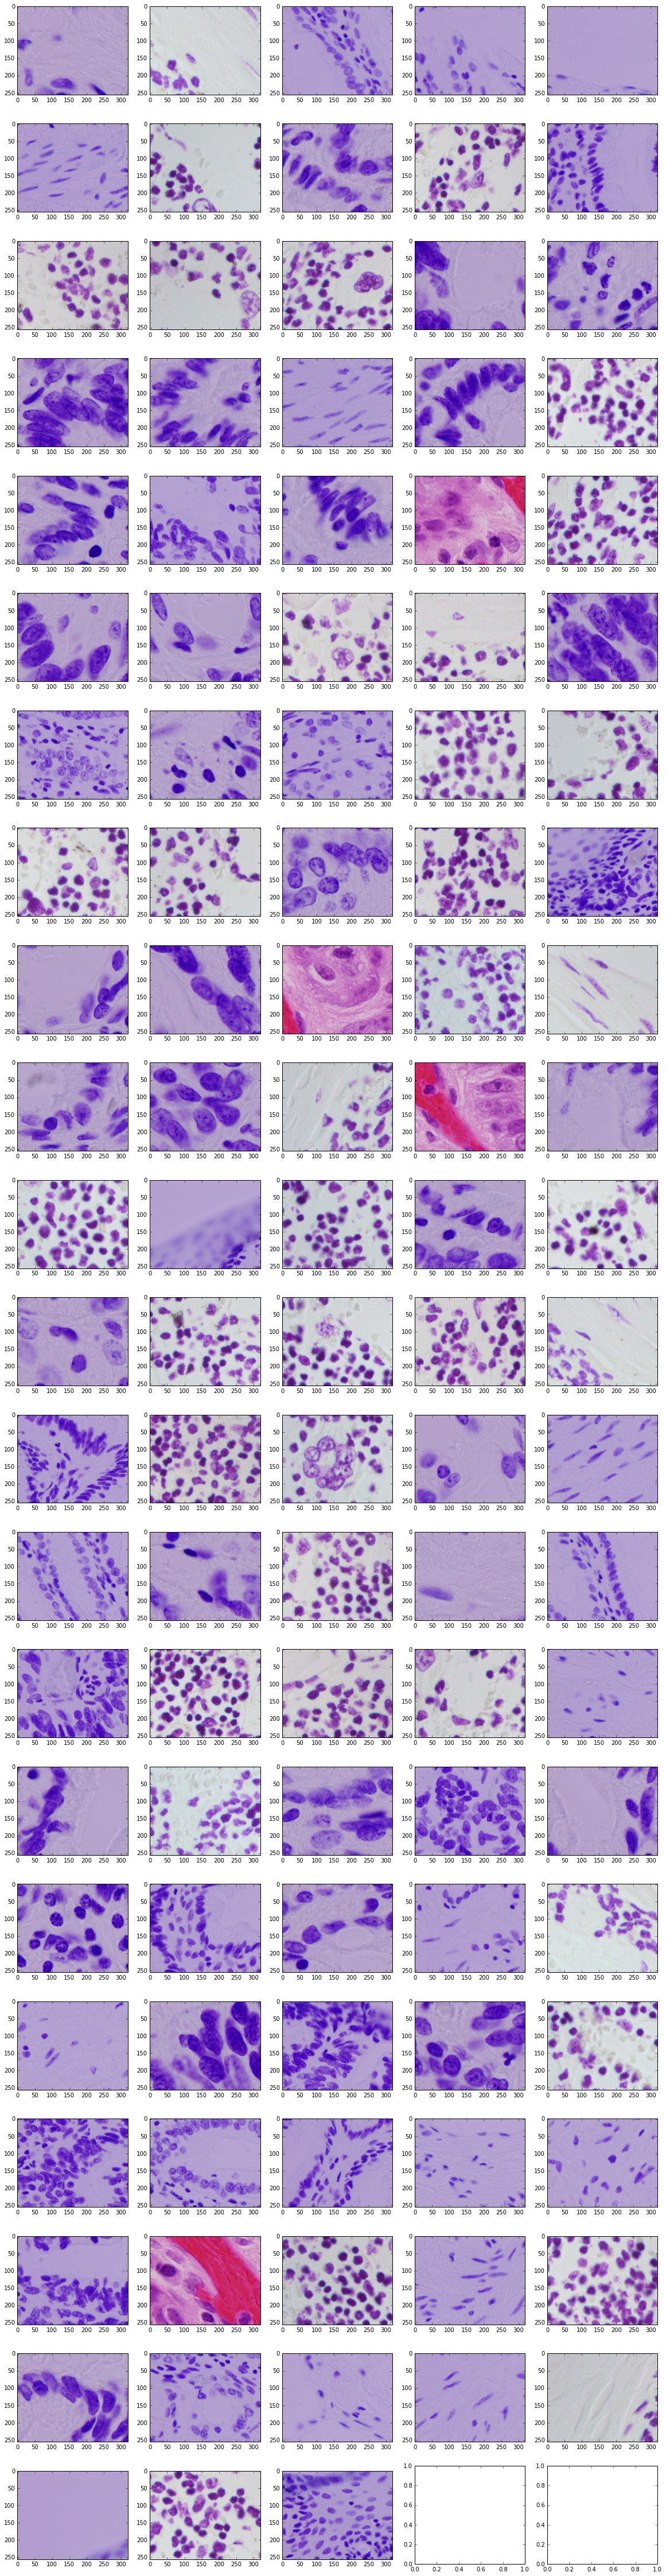

In [4]:
print("Number of color images in dataset : ", len(color_imgs))
fig, axes = plt.subplots(22, 5, figsize=(20, 80))
axes = axes.flatten()

for i, img_file in enumerate(color_imgs):
    img = plt.imread(img_file)
    axes[i].imshow(img)

### Get image statistics 
RGB mean and standard deviation

In [5]:
# statistics
imgs_mean, imgs_var, imgs_n = [], [], []
for img_file in tqdm(color_imgs):
    img = plt.imread(img_file)
    imgs_mean.append(np.mean(img, axis=(0, 1)))
    imgs_var.append(np.var(img, axis=(0, 1)))
    imgs_n.append(img.shape[0] * img.shape[1])
    
imgs_mean = np.array(imgs_mean)
imgs_var = np.array(imgs_var)
imgs_n = np.array(imgs_n)


rgba_mean = np.dot(imgs_n, imgs_mean) / np.sum(imgs_n)
delta_mean =  np.dot(imgs_n, np.square(imgs_mean - rgba_mean))
sum_var = np.dot((imgs_n - 1), imgs_var)
rgba_stddev = np.sqrt((sum_var + delta_mean) / (np.sum(imgs_n) - 1)) 

print("RGBA mean : ",  rgba_mean)
print("RGBA std dev : ",  rgba_stddev)

100%|██████████| 108/108 [00:00<00:00, 138.71it/s]

RGBA mean :  [ 0.67112247  0.57436889  0.78549767  1.        ]
RGBA std dev :  [ 0.13055238  0.20516671  0.065434    0.        ]


### Create direction masks from instance masks and display them

In [6]:
def get_bboxes_and_masks(img, masks, min_pixel=3):
    """Returns bboxes, instance masks, direction mask"""
    bboxes = []
    instance_masks = []
    direction_masks = {i: [[], []] for i in range(16)}
    for mask in masks:
        roi = np.where(mask == 1)
        y_min, x_min = np.min(roi, axis=1)
        y_max, x_max = np.max(roi, axis=1)
        h, w = (y_max - y_min, x_max - x_min)
        if (h < min_pixel) or (w < min_pixel):
            continue
        bboxes.append([y_min, x_min, h, w])
        instance_masks.append(roi)
        mask_roi = mask[y_min:y_max+1, x_min:x_max+1]
        c = mask_roi == 1
        x, y = np.meshgrid(np.arange(w+1), np.arange(h+1))
        cond1 = (x > w/2.)
        cond2 = (y > h/2.)
        cond3 = (abs(y-h/2.) > 1.*h/w * abs(x-w/2.))
        cond4 = (abs(x - w/2.) < w/4.) & (abs(y - h/2.) < h/4.)
        i = 0
        for c1 in [cond1, ~cond1]:
            for c2 in [cond2, ~cond2]:
                for c3 in [cond3, ~cond3]:
                    for c4 in [cond4, ~cond4]:
                        y, x = np.where(c & c1 & c2 & c3 & c4)
                        direction_masks[i][0] += list(y + y_min)
                        direction_masks[i][1] += list(x + x_min)
                        i += 1
    return bboxes, instance_masks, direction_masks

def display_bboxes_and_masks(img, masks, min_pixel=3, line_thickness=2):
    bboxes, instance_masks, bins = get_bboxes_and_masks(img, masks, min_pixel)
    instance_mask = np.zeros_like(img)
    dir_mask = np.zeros_like(img)
    colors = cm.rainbow(np.linspace(0, 1, 16))
    i = 0
    for i in range(16):
        y, x = bins[i]
        dir_mask[(y, x)] = colors[i]
    for y, x, h, w in bboxes:
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (1., 1., 0., 1), line_thickness)
    colors = cm.rainbow(np.linspace(0, 1, len(instance_masks)))
    for instance, c in zip(instance_masks, colors):
        instance_mask[instance] = c
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[1].imshow(instance_mask)
    ax[2].imshow(dir_mask)

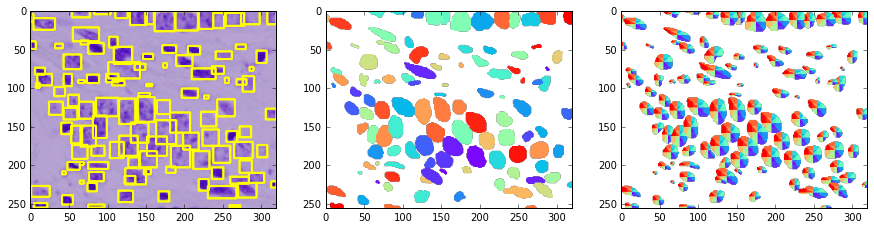

In [7]:
img_file = color_imgs[30]
img = plt.imread(img_file)
mask_dir = os.path.dirname(img_file).replace('images', 'masks')
mask_files = glob(mask_dir + '/*.png')
masks = [plt.imread(f) for f in mask_files]
display_bboxes_and_masks(img, masks)

### Bbox statistics

In [8]:
all_bboxes = []
for img_file in tqdm(color_imgs):
    img = plt.imread(img_file)
    mask_dir = os.path.dirname(img_file).replace('images', 'masks')
    mask_files = glob(mask_dir + '/*.png')
    masks = [plt.imread(f) for f in mask_files]
    bboxes, _, _ = get_bboxes_and_masks(img, masks, min_pixel=3)
    all_bboxes += bboxes
all_bboxes = np.array(all_bboxes)

100%|██████████| 108/108 [00:04<00:00, 24.36it/s]


Log mean : 2.90787646029, mean : 18.3178585364
-3.00 sigma log :  1.150, -3.00 sigma :  3.160
-2.00 sigma log :  1.736, -2.00 sigma :  5.676
-1.00 sigma log :  2.322, -1.00 sigma :  10.197
 1.00 sigma log :  3.494,  1.00 sigma :  32.907
 2.00 sigma log :  4.079,  2.00 sigma :  59.114
 3.00 sigma log :  4.665,  3.00 sigma :  106.193
Log mean : -3.13705402102e-18, mean : 1.0
-3.00 sigma log : -1.593, -3.00 sigma :  0.203
-2.00 sigma log : -1.062, -2.00 sigma :  0.346
-1.00 sigma log : -0.531, -1.00 sigma :  0.588
 1.00 sigma log :  0.531,  1.00 sigma :  1.701
 2.00 sigma log :  1.062,  2.00 sigma :  2.893
 3.00 sigma log :  1.593,  3.00 sigma :  4.921


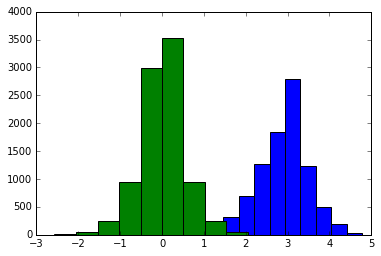

In [9]:
a = all_bboxes[:, 2:].flatten()
log_a = np.log(a)
plt.hist(log_a)
a_mean = np.mean(log_a)
a_std = np.std(log_a)
print("Log mean : {}, mean : {}".format(a_mean, np.exp(a_mean)))
for n_sigma in [-3, -2, -1, 1, 2, 3]:
    print("{0: 3.2f} sigma log : {1: 3.3f}, {0: 3.2f} sigma : {2: 3.3f}"
          .format(n_sigma, a_mean + n_sigma * a_std, np.exp(a_mean + n_sigma * a_std)))
r = all_bboxes[:, 2] * 1. / all_bboxes[:, 3]
r = np.concatenate((r, 1./r))
log_r = np.log(r)
plt.hist(log_r)
r_mean = np.mean(log_r)
r_std = np.std(log_r)
print("Log mean : {}, mean : {}".format(r_mean, np.exp(r_mean)))
for n_sigma in [-3, -2, -1, 1, 2, 3]:
    print("{0: 3.2f} sigma log : {1: 3.3f}, {0: 3.2f} sigma : {2: 3.3f}"
          .format(n_sigma, r_mean + n_sigma * r_std, np.exp(r_mean + n_sigma * r_std)))

### train-validation split
We split 108 images to training set with 96 and validation set with 12 images. To capture data variation, we use clustering to make the split.  

In [10]:
from sklearn.cluster import KMeans

all_bboxes = []
n_bboxes = []
for img_file in tqdm(color_imgs):
    img = plt.imread(img_file)
    mask_dir = os.path.dirname(img_file).replace('images', 'masks')
    mask_files = glob(mask_dir + '/*.png')
    masks = [plt.imread(f) for f in mask_files]
    bboxes, _, _ = get_bboxes_and_masks(img, masks, min_pixel=3)
    n_bboxes += [len(bboxes)]
    all_bboxes += [np.mean(bboxes, axis=0)[2:]]
all_bboxes = np.array(all_bboxes)
r = all_bboxes[:, 1] * 1./all_bboxes[:, 0]
r = np.maximum(r, 1./r)
a = np.mean(all_bboxes, axis=1)
X = np.hstack((np.expand_dims(a, 1)/60., np.expand_dims(n_bboxes, 1)/100., 
               imgs_mean[:, :3], imgs_var[:, :3], np.expand_dims(r, 1)/3.))
kmeans = KMeans(n_clusters=12, random_state=0).fit(X)
clus = kmeans.predict(X)
print("clusters : ", clus)
_, indices = np.unique(clus, return_index=True)
val_idx = indices
train_idx = [i for i in range(len(clus)) if i not in val_idx]

100%|██████████| 108/108 [00:04<00:00, 25.31it/s]


clusters :  [ 4  1  5  7  6  7  0  4  0  2  0  0  5  8  1  3  4  7  4  5  4  5  4 10  5
  8  4  0  0  3 11  1  2  5  0  5  0  8  5  9  1  3 10  2  8  4  3  0 10  1
  5  7  5  4  0  8  5  0  5  0 11  2  0  8  7  2  4  5  6  5  2  2  5  0  7
  4  5  4  2  4  4 11  4  7  0  1  3 11  3  0 11  2  2  7  7  5 10  5  7  5
  4  2  7  1  1  1  5 11]


Number of images in training set :  96
Number of images in validation set :  12


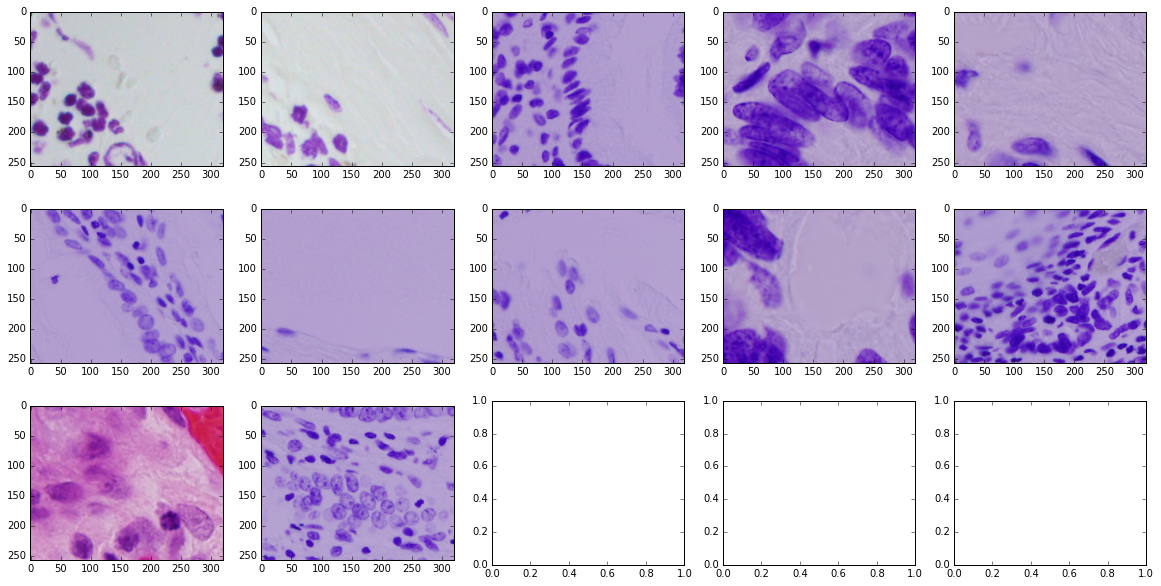

In [11]:
print("Number of images in training set : ", len(train_idx))
print("Number of images in validation set : ", len(val_idx))
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

for ax, idx in zip(axes, val_idx):
    img = plt.imread(color_imgs[idx])
    ax.imshow(img)

### Data Augmentation
For each image, we extract 128 x 128 patches such that two neighboring patches are 32 pixels apart (either x or y direction). This yields 7x5=35 patches. For each patch, we perform augmentation using rotations by 90, 180 and 270 degrees as well as horizontal and vertical flipping. Thus, we get 210 patches per image leading to 210x96=20160 training patches and 168x12=2520 validation patches.  

In [12]:
def rotate_image(img, theta):
    if theta%360 == 90:
        out = cv2.transpose(img)
        return cv2.flip(out, 1)
    elif theta%360 == 180:
        out = cv2.flip(img, 1)
        return cv2.flip(out, 0)
    elif theta%360 == 270:
        out = cv2.transpose(img)
        return cv2.flip(out, 0) 
    else:
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2., h/2.), theta, 1.)
        return cv2.warpAffine(img, M, (w, h))

def flip_image(img, axis):
    return cv2.flip(img, axis)

def split_image_and_masks(img, masks, a=128, delta_a=32, augment=True):
    h, w = img.shape[:2]
    masks = np.array(masks)
    split_images, split_masks = [], []
    for y in range(0, h-a+1, delta_a):
        for x in range(0, w-a+1, delta_a):
            crop_img = img[y:y+a, x:x+a]
            split_images.append(crop_img)
            crop_masks = masks[:, y:y+a, x:x+a]
            crop_masks_nonempty = []
            for mask in crop_masks:
                roi = np.where(mask == 1)
                if len(roi[0]) > 0:
                    crop_masks_nonempty.append(mask)
            split_masks.append(crop_masks_nonempty)
            if augment:
                for theta in [90, 180, 270]:
                    aug_img = rotate_image(crop_img, theta)
                    aug_masks = [rotate_image(m, theta) 
                                 for m in crop_masks_nonempty]
                    split_images.append(aug_img)
                    split_masks.append(aug_masks)
                for flip_axis in [0, 1]:
                    aug_img = flip_image(crop_img, flip_axis)
                    aug_masks = [flip_image(m, flip_axis)
                                 for m in crop_masks_nonempty]
                    split_images.append(aug_img)
                    split_masks.append(aug_masks)
    return split_images, split_masks

Number of patches per image :  210


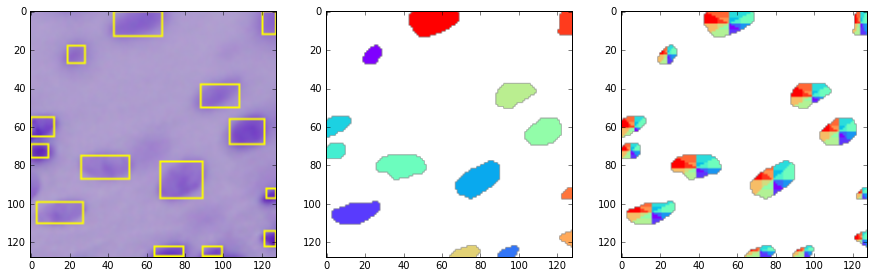

In [13]:
img_file = color_imgs[39]
img = plt.imread(img_file)
mask_dir = os.path.dirname(img_file).replace('images', 'masks')
mask_files = glob(mask_dir + '/*.png')
masks = [plt.imread(f) for f in mask_files]
split_imgs, split_masks = split_image_and_masks(img, masks)
print("Number of patches per image : ", len(split_imgs))
display_bboxes_and_masks(split_imgs[0], split_masks[0], line_thickness=1)

### Save augmented training and validation images

In [16]:
def read_image_and_masks(img_file):
    img = plt.imread(img_file)
    mask_dir = os.path.dirname(img_file).replace('images', 'masks')
    mask_files = glob(mask_dir + '/*.png')
    masks = [plt.imread(f) for f in mask_files]
    return img, masks
    

def save_as_npz(img, masks, filename):
    h, w, _ = img.shape
    instance_mask = np.zeros((h, w), dtype=np.uint8)
    dir_mask = np.zeros((h, w), dtype=np.uint8)
    bboxes, instance_masks, dir_bins = get_bboxes_and_masks(img, masks)
    for i, instance in enumerate(instance_masks):
        instance_mask[instance] = i+1
    for i in range(16):
        y, x = dir_bins[i]
        dir_mask[(y, x)] = i+1
    bboxes = np.array(bboxes)
    np.savez(filename, image=img[:, :, :3], bboxes=bboxes,
             instances=instance_mask, directions=dir_mask)

new_DATA_DIR = '/media/storage/Kaggle/train/data_1'
train_DIR = os.path.join(new_DATA_DIR, 'train')
val_DIR = os.path.join(new_DATA_DIR, 'val')
if not os.path.exists(new_DATA_DIR):
    os.makedirs(train_DIR)
    os.makedirs(val_DIR)

print("Building training set. This may take a while...")
for idx in tqdm(train_idx):
    img_file = color_imgs[idx]
    img, masks = read_image_and_masks(img_file)
    split_imgs, split_masks = split_image_and_masks(img, masks)
    for i, (img, masks) in enumerate(zip(split_imgs, split_masks)):
        filename = '{}_{}.npz'.format(str(idx).zfill(3), str(i).zfill(3))
        filename = os.path.join(train_DIR, filename)
        save_as_npz(img, masks, filename)
        
print("Building validation set. This may take a while...")
for idx in tqdm(val_idx):
    img_file = color_imgs[idx]
    img, masks = read_image_and_masks(img_file)
    split_imgs, split_masks = split_image_and_masks(img, masks)
    for i, (img, masks) in enumerate(zip(split_imgs, split_masks)):
        filename = '{}_{}.npz'.format(str(idx).zfill(3), str(i).zfill(3))
        filename = os.path.join(val_DIR, filename)
        save_as_npz(img, masks, filename)

  0%|          | 0/96 [00:00<?, ?it/s]

Building training set. This may take a while...


  0%|          | 0/12 [00:00<?, ?it/s]

Building validation set. This may take a while...


100%|██████████| 12/12 [00:22<00:00,  1.85s/it]
